# Machine learning avec les modules Python tensorflow2/keras 

Les concepts de base du *Machine Learning* (ML) peuvent être consultés si besoin dans le notebook du TP1 :  `TP1_MNIST-dense.ipynb`.

## Entraînement / exploitation d'un réseau de neurones convolutionnel pour la reconnaissance de chiffres manuscrits

L'objectif du TP2 est de comprendre le fonctionnement d'un réseau de neurones convolutionnel et de mettre en oeuvre sa construction à l'aide du module **keras**, utilisé comme interface *high level* du module **tensorflow**. <br />

Le séquencement de ce TP reste le même que celui du TP1 :
- Rappels sur le fonctionnement des réseaux convolutionels
- Chargement des images depuis la banque MNIST.<br>
Dans ce TP les images ne sont pas applaties en vecteurs car un réseau convolutionnel accepte des tableaux multidimensionnels en entrée.
- Construction du modèle avec *keras*.
- *one-hot encoding* des labels des images pour les rendre compatibles avec les sorties du réseau de neurones.
- Entrainement & analyse des résultats.

# A/ Les Réseaux de Neurones Convolutionnels (RNC)

## 1 - Principe

Les Réseaux de Neurones Convolutionnel (RNC, en anglais *CNN* :*Convolutionnal Neural Networl*) proposent des structures particulièrement efficaces pour l'analyse du contenu des images. Pour cela les RNC mettent en oeuvre des traitements et une architecture et bien spécifiques :
- la convolution des images par des noyaux adaptés (filtre convolutif)
- le *pooling* pour réduire la quantité d'information générée par les convolutions,
- une architecture qui enchaîne "convolution > pooling > convolution > pooling...." chargée d'extraire les caractéristiques de l'image (*features*) qui sont ensuite vectorisées et envoyées en entrée d'un réseau dense chargé de l'étape de classification.

Dans la suite du TP, nous construirons le RNC `LeNet5`, un des premiers RNC proposé par Yann LeCun *et al.* dans les années 90 pour la reconnaisannce des images MNIST :

<p style="text-align:center; font-style:italic; font-size:12px;">
    <img src="img/LeNet5.png" ><br>
    [Lecun, Y.; Bottou, L.; Bengio, Y.; Haffner, P. (1998). "Gradient-based learning applied to document recognition". Proceedings of the IEEE. 86 (11): 2278–2324. doi:10.1109/5.726791.]
</p>

### Extraction des caractéristiques d'une image par convolution

La convolution d'une image par un filtre (aussi appelé noyau, *kernel*) consiste à déplacer une 'petite' matrice 2D ( 3x3, 5x5 ....) sur l'image et à calculer à chaque fois le produit tensoriel contracté entre les élements du filtre et les pixels de l'image délimités par le filtre (somme des produits terme à terme).<br>

L'animation ci-dessous illustre la convolution d'une image 5x5 par un filtre 3x3 sans *padding* sur les bords : on obtient une nouvelle image plus petite de 3x3 pixels<br>
<p style="text-align:center; font-style:italic; font-size:12px;">
    <img src="img/filter_3x3.png" width="80" style="display:inline-block;">
    <img src="img/Convolution_schematic.gif" width="300" style="display:inline-block;"><br>
    [crédit image : http://deeplearning.stanford.edu/tutorial]
</p>

Pour conserver la taille de l'image traitée, on peut faire appel à une technique de *padding* pour créer de  nouvelles données sur les bords de l'image (par dupplication des données sur les bords par exemple) : 

<p style="text-align:center; font-style:italic; font-size:12px;">
    <img src="img/padding.gif" width="350"><br>
    [crédit image : <a href="https://towardsdatascience.com/applied-deep-learning-part-4-convolutional-neural-networks-584bc134c1e2"> Arden Dertat</a> ]
</p>

Le but de la convolution est d'extraire des caractéristiques particulières présentes dans l'image source : on parle de carte des caratéristiques (*feature map*) pour désigner l'image produite par l'opération de convolution. L'état de l'art conduit à utiliser plusieurs filtres capables d'extraire des caractéristiques différentes : on peut avoir jusqu'à plusieurs dizaines de filtres différents qui génère autant de *feature map*.

#### Exemples simples d'extraction de caractéristiques par filtrage convolutionnel :
La figure ci-dessous montre les 4 *features maps* obtenues en convoluant une image MNIST (un chiffre 7) avec 4 filtres 3x3 simplifiés :

<p style="text-align:center; font-style:italic; font-size:12px;">
    <img src="img/7_mnist_4_filtres.png" width="500"><br>
    [crédit image : JLC]
</p>

On voit que les 4 filtres agissent comme des filtres de détection de contour : dans les images de sortie, les pixels les plus blancs constituent ce que le filtre ont détecté :
- les filtre (a) et (c) détectent des contours horizontaux supérieurs et inférieurs,
- les filtre (b) et (d) détectent des contours verticaux gauches et droits.
Ces exemples sont extrèmement simplifiés mais permettent de comprendre comment focntione le filtrage convolutionnel.

###### Cas général : images RGB traitée par plusieurs filtres de convolution

Dans le cas général où les images correpondent à des tableaux 3D pour les 3 couleurs R(ed), G(reeen) &  B(lue), le filtre de convolution est lui aussi un tableau 3D. L'opération de convolution reste identique : pour une position du filtre 3D sur l'image, le produit tensoriel contracté du filtre avec le sous-tableau 3D correspondant dans l'image fournit un nombre scalaire, et le balayage du procédé sur toute l'image donne un la matrice des caratérisques de l'image. 

Par exemple sii l'on utilise 10 filtres de convolution de 5 x 5 différents (10 array de dimensions (5,5,3)) avec une image RGB de 32 x 32 pixels (array de dimension (32,32,3), on obtient un tableau des caractériques de dimensions (32,32,10), soit 10240 termes alors que l'image source n'en a que 1024 !

<p style="text-align:center; font-style:italic; font-size:12px;">
    <img src="img/conv_3D_10.png" width="350"><br>
    [crédit image : <a href="https://towardsdatascience.com/applied-deep-learning-part-4-convolutional-neural-networks-584bc134c1e2"> Arden Dertat</a> ]
</p>

Pour réduire la quantité d'information générée par les filtres de convolution sans perdre trop d'information, la convolution est toujours suivie d'une opération de *polling*.

### Le *pooling*

Le *pooling* permet de réduire la quantité de donnée à traiter. Comme pour l'opération de convolution, on déplace un filtre sur les éléments de la matrice des caractéristiques, et on calcule un nombre représentant les éléments sélectionnés dans le filtre (par exemple la valeur maximale, ou la moyenne....). Mais contrairement à la convoltion, on déplace le filtre sans recouvrement.<br>
Dans l'exemple simplifié ci-dessous, le filtre *max spool* transforme la matrice 8x8 en une matrice 4x4 qui contient "à peu près" la même information :
<p style="text-align:center; font-style:italic; font-size:12px;">
    <img src="img/max_pool_2x2.png" width="350"><br>
    [crédit image : JLC</a> ]
</p>

## Environnement Python de travail

<div class="alert alert-block alert-danger">
<span style="color:brown;font-family:arial;font-size:normal"> 
L'état de l'art actuel des projets de machine learning sous Python préconise l'utilisation d'un <span style="font-weight:bold;">environnement virtuel Python3</span> qui permet de maîtriser pour chaque projet les versions des modules Python "sensibles" (comme tensorflow par xemple) : dans le cas d'un démarrage de l'ordinateur avec une clef USB Ubuntu, on peut considérer que la clef fournit un environnement Python dédié  (celui de la clef), à condition de ne pas faire de mises à jour des paquets Python avec <span style="font-style:italic">pip install...</span>
    
Dans le cas contraire, le document <span style="font-style:italic">EnvironnementPython_tf2.pdf</span> explique comment créer un environnement Python dédié pour le travail avec le module tensorflow.
</span>
</div>

### Modules Python tensorflow/keras

Le module **keras** qui permet une manipulation de haut niveau des objets **tensorflow** est intégré dans le module **tensorflow** (tf) depuis la version 2. <br>
La documentation du module **tf.keras** à consulter pour ce TP est ici : https://www.tensorflow.org/api_docs/python/tf/keras. 

Versions des modules Python validées pour ce TP sous Ubuntu 20 / Python3.8.5 :
- tensorflow 2.4.0 incluant tensorflow.keras 2.4.0
- OpenCV 4.2.0

In [1]:
import tensorflow as tf
from tensorflow import keras
import sys, cv2
print(f"Python    : {sys.version.split()[0]}")
print(f"tensorflow: {tf.__version__} incluant keras {keras.__version__}")
print(f"OpenCV    : {cv2.__version__}")

Python    : 3.8.5
tensorflow: 2.4.0 incluant keras 2.4.0
OpenCV    : 4.2.0


#### Incrustation des tracés matplotlib dans le cahier IPython et import de modules utiles :

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

#### Affectation des graines (*seed*) des générateurs pseudo-aléatoires :

In [11]:
SEED = 123
np.random.seed(SEED)      
tf.random.set_seed(1234)

# C/ Travail à faire

## 1 - Récupération et mise en fomrme des données MNIST

Plus de détails sur les images MNIST sont donnés dans le notebook `TP1_MNIST_dense.ipynb`.

Consulter la documentation de la fonction `load_data` sur la page [tf.keras.datasets.mnist.load_data](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist/load_data) puis compléter la cellule ci-dessous pour charger les données du MNIST en nommant les données renvoyées :<br>
- `im_train`, `im_test` pour les images d'entraînement et de test,
- `lab_train`, `lab_test` pour les labels des données d'entraînement et de test.

In [5]:
(im_train, lab_train), (im_test, lab_test) = tf.keras.datasets.mnist.load_data()

La cellule ci-dessous affiche les attributs `shape` et `dtype` des tableaux numpy obtenus : les valeurs son-elles cohérentes ?

In [10]:
print("im_train -> shape:", im_train.shape, ", dtype:", im_train.dtype,)
print("im_test  -> shape:", im_test.shape,  ", dtype:", im_test.dtype,)
print("lab_train-> shape:", lab_train.shape,  ", dtype:", lab_train.dtype)
print("lab_test -> shape:", lab_test.shape,  ", dtype:", lab_test.dtype)

im_train -> shape: (60000, 28, 28) , dtype: uint8
im_test  -> shape: (10000, 28, 28) , dtype: uint8
lab_train-> shape: (60000,) , dtype: uint8
lab_test -> shape: (10000,) , dtype: uint8


## Mise en forme des données d'entrée

Les couches convolutionnelles du module keras attendent des tableaux multidimentionnels de la forme `(batch_size, width, height, dpth)` :
- `batch_size` : nombre d'image enentrée,
- `width` et `height` : largeur et hauteur des images (en pixels),
- `depth` : profondeur des tableaux (`3` pour une image RGB, `1` pour une image en ton de gris).

La forme des images MNIST est :

In [7]:
im_train.shape, im_test.shape

((60000, 28, 28), (10000, 28, 28))

Il faut donc rajouter une dimension (égale à `1`) après la troisième dimension `28`. Il ya a au moins deux façons de la faire :
- avec la méthode `reshape` des tableaux `ndarray` de numpy,
- ou avec la fonction `expand_dims` du module tensorflow (cf [tf.expand_dims](https://www.tensorflow.org/api_docs/python/tf/expand_dims)).

Compléter la cellule suivante pour définir `x_train` et `x_test` obtanu sen ajoutant une quatrème dimension aux tableaux `im_train` et `im_test` et en normalisant les valeurs :

In [35]:
# avec  la méthode reshape des tableaux ndarray de numpy :
x_train = im_train.reshape(im_train.shape + (1,))
x_test  = im_test.reshape(im_test.shape + (1,))
x_train, x_test = x_train/ 255.,x_test/255

Vérification :

In [35]:
# avec  la méthode reshape des tableaux ndarray de numpy :
x_train = im_train.reshape(im_train.shape + (1,))
x_test  = im_test.reshape(im_test.shape + (1,))
x_train, x_test = x_train/ 255.,x_test/255

Vérification :

In [40]:
im_train.shape, x_train.shape, im_test.shape, x_test.shape

((60000, 28, 28), (60000, 28, 28, 1), (10000, 28, 28), (10000, 28, 28, 1))

### Mise au format *one-hot* des labels MNIST

Il faut mettre les lables MNIST au format *one-hot* qui permet de calculer l'erreur entre un label et la sortie de la couche de classification du réseau (voir le TP1 pour les détails sur le format *one-hot*).<br>
Consulter la page [tf.keras.utils.to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) sur la fonction `to_categorical` et en déduire comment transformer les tableaux `lab_train` et `lab_test` en tableaux `y_train` et `y_test` contenant des vecteurs encodés *hot-one* :


In [41]:
from tensorflow.keras.utils import to_categorical
# 'one-hot' encoding' des labels :
y_train = to_categorical(lab_train)
y_test  = to_categorical(lab_test)

## 3 - Construction du réseau de neurones

On va maintenant construire dans la cellule ci-dessous un réseau de neurones **convolutionnel** à l'aide du module **keras**.

Comme dans le TP1, on crée un objet instance de la classe `Sequential` (cf [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)) que l'on pourra nommer `net_conv`, puis on complète `net_conv` de façon  incrémentale en ajoutant chaque couche avec la méthode `add` :

- La couche d'entrée de type `InputLayer` (cf [tf.keras.layers.InputLayer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/InputLayer)) sert à spécifier la forme des données d'entrées.<br>
La forme attendue par keras pour des images en entrée est (width,height,dept) : on pourra l'obtenir par exemple avec l'attribut `shape` de n'importe quelle image du jeu `x_train` reformtatté.<br><br>

- Les couches convolutionnelles sont de type `Conv2D` (cf [tf.keras.layers.Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)) :
    - les 2 premiers arguments (positionnels) sont : 
        - le nombre de filtres de la couche
        - la forme du filtre : on peut spécifier  `N` ou `(N,N)` pour spécifier un filtre N x N
    - les autres arguments (nommé) utilisés sont :
        - `stride` : déplacement du filtre de convolution. `stride=1` (équivalent à `(1, 1)`) par exemple pour déplacer le filtre d'un pixel, 
        - `padding=valid` : pas de padding, ou `padding=same` pour obtenir une sortie de même dimensions que l'entrée (défaut : `valid`)
        - `activation` : choix de la focntion d'activation (`'relu'`, '`tanh'`...)<br><br>
        
- Les couches de *poolling* du réseau LeNet5 utilisent un filtre *average pool* qui correspond à la classe `AveragePooling2D`  (cf [tf.keras.layers.AveragePooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D). Les princiapux arguments à utiliser sonts :
    - `pool_size` :  `N` ou `(N,N)` pour spécifier un filtre N x N (défaut : `(2,2)`)
    - `strides` : int, tuple de 2 int, ou None. Si None, prend la même valeur que `pool_size`
    - `padding` : comme pour la classe `Conv2D`<br><br>

- Pour applatir les 16 *feature maps* 5 x 5 en un vecteur de 16*5*5=635 éléments, on peut utiliser une couche de type `Flatten` (cf [tf.keras.layers.Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten))<br><br>

Avec les spécification du réseau Net5 de la figure ci-dessous, on obtient :
- couche d'entrée : `Input(shape=x_train[0].shape)` : on utilise l'attribut `shape` de la 1ère image (28x28 pixels gris) qui vaut (28,28,1).
- couche C1 : `Conv2D(6, 5, padding='same', activation='relu', name='C1')`
- couche S2 : `AveragePooling2D(pool_size=2, name='S2')`
- couche C3 : `Conv2D(16, 5, padding='same', activation='relu', name='C3')`
- couche S4 : `AveragePooling2D(pool_size=2, name='S4')`
- couche d'applissement : `Flatten()`
- couche C5 : `Dense(200, activation='relu', name='C5')`
- couche F5 : `Dense(84, activation='relu', name='F6'`
- couche OUTPUT : `Dense(10, activation='softmax', name='Output')`

Une fois construit, le réseau doit être compilé (au sens de tensorflow) avec la méthdoe `compile` avec les arguments :
- `loss='categorical_crossentropy'` : choix de la fonction d'erreur (cf [tf.keras.categorical_crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/categorical_crossentropy))
- `optimizer='adam'` : choix de l'optimiseur Adam (cf page [tf.keras.optimizers.Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam))
- `metrics=['accuracy']` pour obtenir les données permettant de tracer les courbes de performance.

In [29]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, AveragePooling2D, Flatten

nb_classe = 10

net_conv = Sequential(name='LeNet5')
net_conv.add(Input(shape=x_train[0].shape))
net_conv.add(Conv2D(6, 5, padding='same', activation='relu', name='C1'))
net_conv.add(AveragePooling2D(pool_size=2, name='S2'))
net_conv.add(Conv2D(16, 5, padding='same', activation='relu', name='C3'))
net_conv.add(AveragePooling2D(pool_size=2, name='S4'))
net_conv.add(Flatten())
net_conv.add(Dense(200, activation='relu', name='C5'))
net_conv.add(Dense(84, activation='relu', name='F6'))
net_conv.add(Dense(nb_classes, activation='softmax', name='Output'))
net_conv.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

NameError: name 'nb_classes' is not defined

Avec la méthode `summary` de l'objet `model`, faire afficher la description du modèle : noter les valeurs des paramètres...

In [11]:
net_conv.summary()

Model: "LeNet5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C1 (Conv2D)                  (None, 28, 28, 6)         156       
_________________________________________________________________
S2 (AveragePooling2D)        (None, 14, 14, 6)         0         
_________________________________________________________________
C3 (Conv2D)                  (None, 14, 14, 16)        2416      
_________________________________________________________________
S4 (AveragePooling2D)        (None, 7, 7, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
C5 (Dense)                   (None, 200)               157000    
_________________________________________________________________
F6 (Dense)                   (None, 84)                16884

La fonction `tf.keras.utils.plot_model.plot_model` permet aussi de dessiner la structure du réseau (voir la page [tf.keras.utils.plot_model](https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model)).<br>
Faire tracer la structure du modèle en ajoutant l'option `show_shapes=True` à l'appel de `plot_model` :

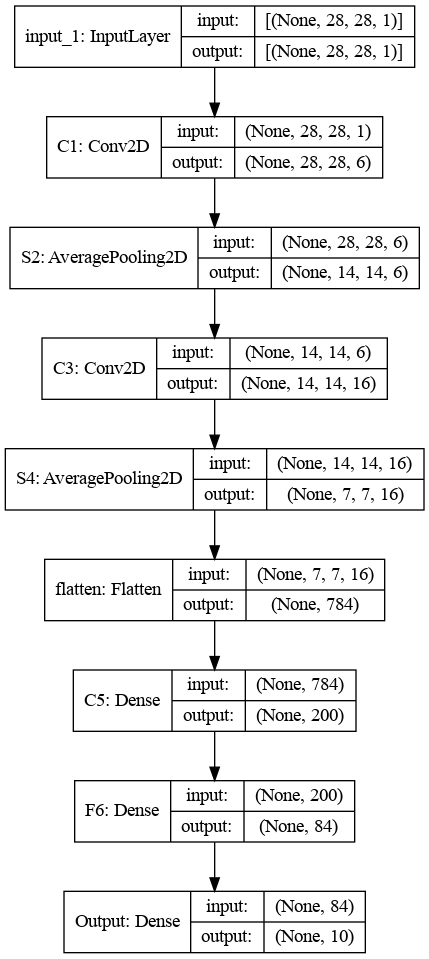

In [12]:
tf.keras.utils.plot_model(lenet5, show_shapes=True)

### Sauvegarde de l'état initial du  réseau

On peut sauvegarder l'état initial des poids du réseau non-entraîné (valeurs aléatoires) avec la méthode `Model.save_weights`. <br>
Ce sera utile plus loin pour remettre le réseau à son état initial avant de relancer d'autres entraînements :

In [13]:
import os

# vérifier que le dossier 'weights' existe et sinon le créer:
if not os.path.exists("weights"): os.mkdir("weights")

# sauvegarde des poinds du réseau initial:
lenet5.save_weights('weights/lenet5_initial')

# afficher les fichiers créés:
files=[os.path.join("weights",f) for f in os.listdir("weights") if f.startswith("lenet5_initial")]
for f in files: print(f)

weights/lenet5_initial.data-00000-of-00001
weights/lenet5_initial.index


Remarque : la méthode `Model.save_weights` utilise on donne le nom `"nenet5_initial"`pour créer plusieurs fichiers préfixés par `"lenet5_initial"`.<br>
Lors de la lecture ultérieure des poids du réseau avec la méthode `Model.load_weights` il suffira de donner le même nom pour que cela fonctionne.

## 4 - Entraînement du réseau

Consulter au besoin la documentation de la méthode `fit` dans la page [tf.keras.Sequential]
(https://www.tensorflow.org/api_docs/python/tf/keras/Sequential). 

Compléter la cellule ci-dessous pour entraîner le réseau en utilisant la méthode `fit` de l'objet `model` avec les arguments :
- `x_train` : les 60000 images 
- `y_train` : les 60000 labels encodés *one-hot*.
- `epochs=5` : faire 5 fois l'entraînement complet.
- `batch_size=128` : découper le jeu des données d'entrée (les 60000 images) en "lots" (*batch*) de taille `batch_size`.<br>
La mise à jour des poids du réseau est faite au bout de `batch_size` échantillons d'entrée. La valeur de `batch_size` (par défaut est 32) est un paramètre qui influe beaucoup sur la qualité de l'apprentissage : on peut essayer d'autres valeurs (64, 128 ...) et observer comment évoluent les performances d'entraînement).



Pour avoir un indicateur réaliste de la qualité du réseau entraîné on peut tester à chaque `epoch` la précison du réseau entraîné en utilisant les données de test : il suffit de passer l'agument `validation_data` à la méthode `fit`, en lui affectant le tuple des données de test `(x_test, y_test)`

In [23]:
# au cas on on exécute plusieurs fois cette cellule, il faut ré-initialiser 
# les poids du réseau à leur valeur initiale si on veut comparer les entraînements...
lenet5.load_weights("weights/lenet5_initial") 

hist = lenet5.fit(x_train, y_train, 
                  validation_data=(x_test, y_test),
                  batch_size=128,
                  epochs=5)

Epoch 1/5
469/469 [==============================] - 23s 48ms/step - loss: 0.4166 - accuracy: 0.8735 - val_loss: 0.0924 - val_accuracy: 0.9694
Epoch 2/5
469/469 [==============================] - 22s 47ms/step - loss: 0.0844 - accuracy: 0.9736 - val_loss: 0.0575 - val_accuracy: 0.9811
Epoch 3/5
469/469 [==============================] - 22s 47ms/step - loss: 0.0599 - accuracy: 0.9814 - val_loss: 0.0465 - val_accuracy: 0.9841
Epoch 4/5
469/469 [==============================] - 22s 46ms/step - loss: 0.0483 - accuracy: 0.9851 - val_loss: 0.0518 - val_accuracy: 0.9829
Epoch 5/5
469/469 [==============================] - 22s 47ms/step - loss: 0.0394 - accuracy: 0.9879 - val_loss: 0.0386 - val_accuracy: 0.9871


L'objet `hist` retourné par la méthode `fit` possède un attribut `history` de type dictionnaire dont les clefs `'loss'`, `'accuracy'` contiennent l'évaluation de la fonction de cout et de la précision du réseau à la fin de chque (*epoch*) avec les données d'entraînement. Les clefs `'val_loss'` et `'val_accuracy'` sont assiciées aux données de test.

In [138]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [27]:
hist.history['loss'], hist.history['accuracy'], hist.history['val_loss'], hist.history['val_accuracy'], 

([0.41658636927604675,
  0.08435337990522385,
  0.05986164137721062,
  0.048280175775289536,
  0.03938527777791023],
 [0.8735499978065491,
  0.9735999703407288,
  0.9814333319664001,
  0.9850666522979736,
  0.9879166483879089],
 [0.09236747771501541,
  0.05745607241988182,
  0.04653725400567055,
  0.05182579904794693,
  0.03864319249987602],
 [0.9693999886512756,
  0.9811000227928162,
  0.9840999841690063,
  0.9829000234603882,
  0.9871000051498413])

## 4 - Entraînement du réseau avec test à chaque `epoch`

### Tracé des courbes `accuracy` et `loss`  de l'entraînement et des test :

La fonction `plot_loss_accuracy` du module `utils.tools` (présent dans le répertoire du notebook) permet de tracer les courbes de précision et de perte en utilisant les données stockées dans l'objet `hist`. Faire tracer ces courbes :

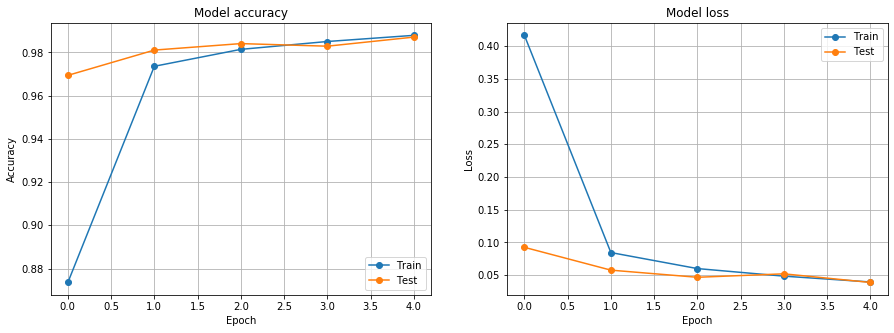

In [28]:
from utils.tools import plot_loss_accuracy
plot_loss_accuracy(hist)

### Arrêter l'entraînement avant *over-fit*

Keras propose des mécanismes permettant d'arrêter automatiquement l'apprentissage en surveillant par exemple la croissance de la précision d'une `epoch` à l'autre.

Le mécanisme consiste à définir des fonction *callback* qui sont utilisées par Keras lors de l'entraînnement grâce à l'agument nommé  `callback` :

In [144]:
from tensorflow.keras.callbacks import EarlyStopping

callbacks_list = [
    EarlyStopping(monitor='val_accuracy',  # la grandeur à surveiller
                  patience=1,              # on accepte que 'val_accuracy' puisse diminuer 2 fois de suite
                  verbose=1)
]

# recharger les valeurs initiasles des poids du réseau:
lenet5.load_weights("weights/lenet5_initial")

hist = lenet5.fit(x_train, y_train,
                  validation_data=(x_test, y_test),
                  epochs=15, 
                  batch_size=128, 
                  callbacks = callbacks_list)

Epoch 1/15
469/469 [==============================] - 26s 55ms/step - loss: 0.3079 - accuracy: 0.9028 - val_loss: 0.0997 - val_accuracy: 0.9692
Epoch 2/15
469/469 [==============================] - 26s 55ms/step - loss: 0.0812 - accuracy: 0.9752 - val_loss: 0.0675 - val_accuracy: 0.9785
Epoch 3/15
469/469 [==============================] - 26s 55ms/step - loss: 0.0555 - accuracy: 0.9829 - val_loss: 0.0555 - val_accuracy: 0.9818
Epoch 4/15
469/469 [==============================] - 25s 52ms/step - loss: 0.0439 - accuracy: 0.9862 - val_loss: 0.0436 - val_accuracy: 0.9867
Epoch 5/15
469/469 [==============================] - 27s 58ms/step - loss: 0.0353 - accuracy: 0.9890 - val_loss: 0.0429 - val_accuracy: 0.9862
Epoch 00005: early stopping


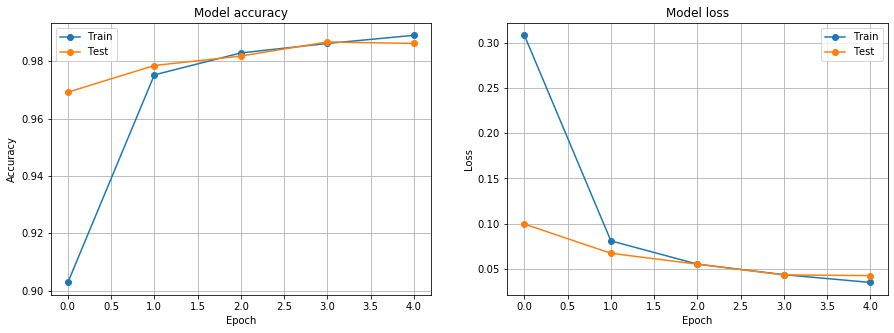

In [145]:
from utils.tools import plot_loss_accuracy
plot_loss_accuracy(hist)

On voit que la précision calculée avec les données de test tend vers une limite voisine de 98%. <br>
On pourrait penser qu'augmenter la valeur de `epochs` permet d'améliorer la précision du réseau... mais on court le risque de sur-entraînner le réseau (*over-fit*).

### Sauvegarder les poids du  réseau entraîné

La méthode `Model.save_weights` permet d'enregistrer les **poids** du réseau entraïné dans un fichier :

In [121]:
import os
# vérifier que le dossier 'weights' existe et sinon le créer:
if not os.path.exists("weights"): os.mkdir("weights")

# sauvegarde des poids du réseau entrainé:
lenet5.save_weights('weights/lenet5_check_points')

# afficher les fichiers créés:
files=[os.path.join("weights",f) for f in os.listdir("weights") if f.startswith("lenet5_check")]
for f in files: print(f)

weights/lenet5_check_points.index
weights/lenet5_check_points.data-00000-of-00001


### Sauvegarder la structure du réseau et ses poids

La méthode `Model.save` permet d'enregistrer **toute la structure et les poids** du réseau entraïné dans un fichier.<br />
Ceci permet de recréer plus tard *from scratch* le réseau entrainé pour passer en phase exploitation du réseau par exemple, en utilisant la fonction`tf.keras.models.load_model` :

In [122]:
import os
# vérifier que le dossier 'weights' existe et sinon le créer:
if not os.path.exists("models"): os.mkdir("models")

# sauvegarder structure réseau + poids :
lenet5.save('models/lenet5_model1') 

# afficher les fichiers créés:
files=[os.path.join("models",f) for f in os.listdir("models") if f.startswith("lenet5_model")]
for f in files: print(f)

INFO:tensorflow:Assets written to: models/lenet5_model1/assets
models/lenet5_model1


## 6/ Exploitation du réseau avec le jeu de test

La méthode `predict` de l'objet `model` permet de calculer la prédiction du réseau pour une ou plusieurs entrées (voir la méthode `predict`dans la page [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)).

La cellule ci-dessous montre la mise en oeuvre de la méthode `predict`, et comment exploiter la représentation  *one-hot* renvoyée par `fit` en utilisant la méthode `argmax` des tableaux de numpy :

sortie du réseau pour l'image de rang 100 :
[4.31112494e-06 1.43875090e-08 8.69669350e-08 6.42541620e-09
 2.46814466e-07 6.60335036e-06 9.99986887e-01 1.48675081e-08
 1.75987509e-06 1.09234986e-08]

sortie réseau arrondie à 1 chiffre : [0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0]
rep[0].argmax() donne : 6

La bonne réponse est 6 soit en 'hot-one' : [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


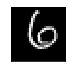

In [123]:
from utils.tools import plot_images

i = 100   # numéro image de test
rep = lenet5.predict(x_test[i:i+1]) # Attention: x doit être un tableau de matrices...
                                   # => x[i] ne convient pas !

print(f"sortie du réseau pour l'image de rang {i} :\n{rep[0]}")

# limiter l'affichage des composantes des tableaux numpy à 1 chiffre :    
with np.printoptions(formatter={'float':'{:.1f}'.format}):    
    print(f"\nsortie réseau arrondie à 1 chiffre : {rep[0]}")
    
print(f"rep[0].argmax() donne : {rep[0].argmax()}")

print(f"\nLa bonne réponse est {lab_test[i]} soit en 'hot-one' : {y_test[i]}")

plot_images(im_test,i,1,1)

#### Utilité de la méthode numpy `ndarray.argmax` pour décoder le tableau de vecteurs *one-hot* renvoyé par la méthode `predict`

Quand on calcule la prédiction du réseau `model` avec les données de test par exemple, on obtient un résultat qui est un tableau de vecteurs codés *one-hot*, comme le détaille la cellue suivante :

In [124]:
results = lenet5.predict(x_test)
print("forme du tableau 'results':", results.shape)
print("allure des vecteurs du tableau 'result', par exemple :")
with np.printoptions(formatter={'float':'{:.4f}'.format}): 
    print("results[0]  :", results[0])
    print("results[-1] :", results[-1])

forme du tableau 'results': (10000, 10)
allure des vecteurs du tableau 'result', par exemple :
results[0]  : [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000]
results[-1] : [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000]


En écrivant `results.argmax(axe=-1)`, on obtient le tableau des `argmax` de chaque vecteur -> c'est directement le tableau des chiffres reconnus par le réseau :

In [125]:
chiffres_reconnus = results.argmax(axis=-1)
print("chiffres_reconnus -> shape:", chiffres_reconnus.shape, ", dtype:", chiffres_reconnus.dtype)
print(f"contenu de chiffres_reconnus : {chiffres_reconnus}")

chiffres_reconnus -> shape: (10000,) , dtype: int64
contenu de chiffres_reconnus : [7 2 1 ... 4 5 6]


En déduire comment calculer le pourcentage d'erreur du réseau entrainé en utilisant les données de test :

###  Afficher la matrice de confusion

La cellule suivante définie la fonction `show_cm_mnist` qui affiche la **matrice de confusion** :

In [126]:
import pandas as pd
from seaborn import heatmap
from sklearn.metrics import confusion_matrix

def show_cm_mnist(target, results, classes):
    # y : actual answers (vector of int)
    # results : the trained network answers (array of 'one-hot' coded vectors)
    # classes : the liste of possible answers
    predicted = np.argmax(results, axis=-1) # tableau d'entiers entre 0 et 9 

    cm = confusion_matrix(target, predicted)
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    plt.figure(figsize=(11,9))
    heatmap(df_cm, annot=True);

L'affichage de la matrice de confusion permet de visualiser :
- sur la diagonale : les bonnes réponses du réseau, avec dans chaque case le nombre de bonnes réponses
- hors diagonale : les erreurs du réseau, avec dans chaque case la fréquence d'apparition de l'erreur.

Faire afficher la matrice de confusion avec les résultats obtenus par le réseau `model` avec la méthode `predict` :

# B/ Challenges

## Faire reconnaître des images originales à un réseau entraîné avec les images MNIST

Plusieurs possibilités :
- utiliser des images crées par vous-même pour l'occasion... 
- utiliser les images du répertoire `chiffres`.

Si vous créez vos propres images, mettez les dans un répertoire spécific et changez le nom du dossier `images_dir` dans la cellule ci-dessous :

In [127]:
import os

# changer le nom du répertoire au besoin :
images_dir = "chiffres"

images = [os.path.join(images_dir,f) for f in os.listdir(images_dir) if f.endswith(".png")]
images.sort()

print("Images du dossier 'chiffres' à reconnaître :")
for im in images: print(im)

Images du dossier 'chiffres' à reconnaître :
chiffres/0.png
chiffres/1.png
chiffres/2.png
chiffres/3.png
chiffres/4.png
chiffres/5.png
chiffres/6.png
chiffres/7.png
chiffres/8.png
chiffres/9.png


### Lecture des fichiers image avec openCV

Les images doivent être convertie en image en ton de gris de 28 x 28 pixels pour pouvoir être traitées par le réseau entraîné sur les images MNIST.

Plusieurs fonctions du module OpenCV pourront être utilisées :
- `cv2.imread` : pour lire un fichier image aux formats standards (PNG, JPG,...)
- `cv2.cvtColor` : pour convertir une image lue par `cv2.imread` en tons de gris
- `cv2.resize` : pour retailler l'image à 28 x 28 pixels.

La cellule ci-dessous montre un exemple de lecture et traitement avec OpenCV des images du dossier `chiffres` qui sont déjà au format 28 x 28 pixels :

In [128]:
import cv2
my_images = []
for image_path in images:
    img = cv2.imread(image_path)                    # lecture fichier image
    img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) # conversion en tons de gris
    my_images.append(img_gray)

Visualisation des images lues :

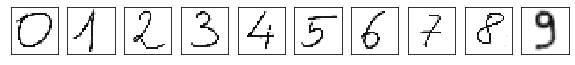

In [129]:
plot_images(my_images, 0, 1, 10)

Inversion des images pour avoir des chiffres doivent être en blanc sur fond noir :

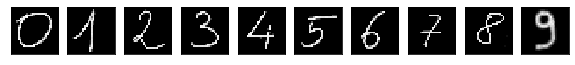

In [130]:
my_images = [255 - im for im in my_images]
plot_images(my_images, 0, 1, 10)

On peut maintenant :
- transformer des matrices 28x28 en vecteurs de float normalisés,
- calculer le prédiction du réseau entaîné de votre choix (`model` ou autre...) avec les images perso en entrée,
- faire afficher la précision obtenue et la matric de confusion.

In [131]:
my_images = np.array(my_images)

nb_images = my_images.shape[0]
nb_pixel  = my_images[0].size

# resize des matrices au format attendu par keras :
my_x = my_images.reshape(my_images.shape + (1,))/255.



[0 1 2 3 4 5 6 7 5 9]


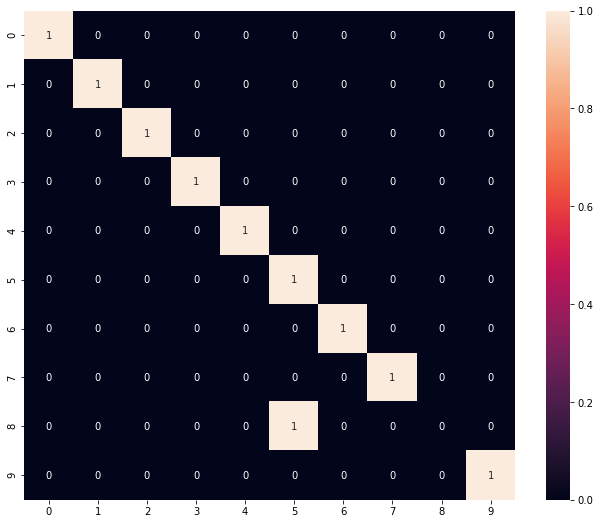

In [146]:
my_results = lenet5.predict(my_x)
print(my_results.argmax(axis=-1))
target    = np.array([0,1,2,3,4,5,6,7,8,9])
show_cm_mnist(target, my_results, range(10))

[0 1 2 3 4 5 6 7 8 9]


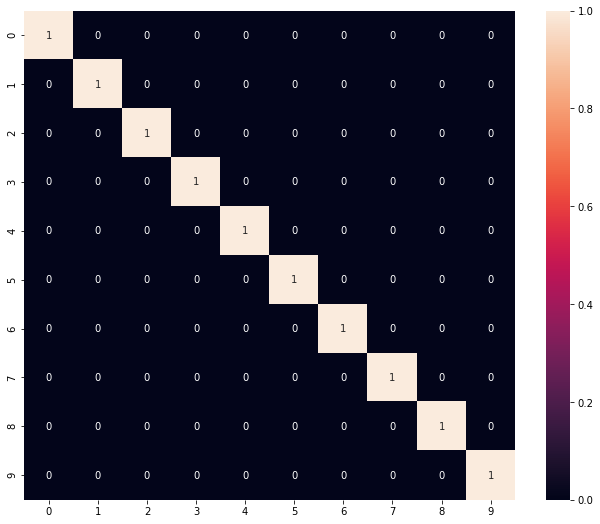

In [132]:
my_results = lenet5.predict(my_x)
print(my_results.argmax(axis=-1))
target    = np.array([0,1,2,3,4,5,6,7,8,9])
show_cm_mnist(target, my_results, range(10))

Que suggèerent les  résultats ?

In [166]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, AveragePooling2D, Flatten, MaxPooling2D

nb_classe = 10
SEED = 123
np.random.seed(SEED)         # python built-in random generator
np.random.seed(SEED)      # numpy random generator
tf.random.set_seed(SEED)  # tensorflow random generator

# les 5 lignes pour construire le réseau de neurones:

lenet5 = Sequential(name='LeNet5')
lenet5.add(keras.Input(shape=x_train[0].shape))
lenet5.add(Conv2D(30, 5, padding='same', activation='relu', name='C1'))
lenet5.add(MaxPooling2D(name='S2'))
lenet5.add(Conv2D(15, 3, padding='valid', activation='relu', name='C3'))
lenet5.add(MaxPooling2D(name='S4'))
lenet5.add(Flatten())
lenet5.add(Dense(128, activation='relu', name='C5'))
lenet5.add(Dense(50, activation='relu', name='F6'))
lenet5.add(Dense(10, activation='softmax', name='Output'))
lenet5.compile(loss='categorical_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy'])

# Autres ressources intéressantes... des vidéos :

In [133]:
%%HTML
<iframe src="https://www.youtube.com/embed/trWrEWfhTVg" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [134]:
%%HTML
<iframe src="https://www.youtube.com/embed/aircAruvnKk" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [135]:
%%HTML
<iframe src="https://www.youtube.com/embed/IHZwWFHWa-w" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [136]:
%%HTML
<iframe src="https://www.youtube.com/embed/Ilg3gGewQ5U" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>